# Assignment 3 Exercise 2

## Description
Use `negative selection` to detect the anomalous sequences in the system calls dataset: `snd-cert`

Perform an AUC analysis to evaluate the quality of your classification. Choose the parameters n and r for the negative selection algorithm yourself. You can use the parameters from the language example as a starting point.

In [1]:
import math
import pickle
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm_notebook as tqdm

In [2]:
# global variables
CERT = "negative-selection/syscalls/snd-cert/"
UNM = "negative-selection/syscalls/snd-unm/"
OUT = "syscalls-classification/"
OVERLAP = False
CHUNK_LENGTH = 7
TEST_N = 3

Max value of `CHUNK_LENGTH` = 7 because that is the smallest sequence length in the given training dataset. 

### Step 1: Dataset Pre-processing

Define helper functions for pre-processing datasets

In [3]:
def read_data(path):
    '''function to read files'''
    with open(path, "r") as data:
        lines = data.read().splitlines()
    return lines

def fixed_length_chunks(string, length, overlap=False):
    '''function to create a fixed length chunks of a dataset'''
    step = 1 if overlap else length
    max_step = max(len(string) - length + 1, 1) if overlap else len(string)
    chunks = list( (string[i:length+i] for i in range(0, max_step, step)) )
    if not overlap:
        last_chunk_length_diff = length - len(chunks[-1])
        # force last chunk to be fixed length by adding a part from the penultimate chunk
        if len(chunks) > 1 and last_chunk_length_diff != 0:
            chunks[-1] = (chunks[-2] + chunks[-1])[-length:]
    return chunks

Functions for training data

In [4]:
def remove_duplicates(chunks):
    """Removes duplicate chunks (use only for training data)."""
    duplicates = set()
    output = []
    for chunk in chunks:
        if chunk not in duplicates:
            duplicates.add(chunk)
            output.append(chunk)
    return output

def process_train_sequences(sequences, chunk_length, overlap):
    '''function to create fixed length chunks and remove duplicates'''
    chunked_sequences = [fixed_length_chunks(seq, chunk_length, overlap) for seq in sequences]
    chunks = [chunk for chunks in chunked_sequences for chunk in chunks]
    return remove_duplicates(chunks)    

def write_train_data(chunks, out_dir):
    '''function to write chunks in a file'''
    with open(out_dir, "w") as train:
        train.write('\n'.join(chunks))

Functions for test data

In [5]:
def read_test_and_labels(path_no_ext):
    '''function to fetch test dataset files'''
    test = read_data(path_no_ext + ".test")
    labels = read_data(path_no_ext + ".labels")
    return test, labels

def process_test_sequences(labeled_sequences, chunk_length, overlap):
    '''function to create fixed length chunks and remove duplicates'''
    chunked_sequences = [list(map(lambda x: (x, seq_lab[1], i), 
                                  fixed_length_chunks(seq_lab[0], chunk_length, overlap)
                                 )
                             )
                         for i, seq_lab in enumerate(labeled_sequences)]
    chunks = [chunk for chunks in chunked_sequences for chunk in chunks]
    return chunks

def write_test_data(labeled_chunks, out_dir_no_ext):
    '''function to write chunks in a file'''
    chunks = [chunk for chunk, _, _ in labeled_chunks]
    lbls = [label for _, label, _ in labeled_chunks]
    idxs = [str(idx) for _, _, idx in labeled_chunks]
    
    with open(out_dir_no_ext + ".test", "w") as test, open(out_dir_no_ext + ".labels", "w") as labels, open(out_dir_no_ext + ".txt", "w") as identifiers:
        test.write('\n'.join(chunks))
        labels.write('\n'.join(lbls))
        identifiers.write('\n'.join(idxs))

Functions for preprocessing datasets

In [6]:
def preprocess_train_data(chunk_length, overlap):
    # snd-cert
    train_cert = read_data(CERT + "snd-cert.train")
    chunks_cert = process_train_sequences(train_cert, chunk_length, overlap)
    write_train_data(chunks_cert, OUT + "snd-cert/snd-cert.{}.train".format(chunk_length))
    
def preprocess_test_data(chunk_length, overlap):
    for i in range(1, 4):
        # snd-cert
        test_cert, labels_cert = read_test_and_labels(CERT + f"snd-cert.{i}")
        labeled_chunks_cert = process_test_sequences(zip(test_cert, labels_cert), chunk_length, overlap)
        write_test_data(labeled_chunks_cert, OUT + f"snd-cert/snd-cert.{chunk_length}.{i}")

Pre-process training and test datasets

In [7]:
for chk_len in tqdm(range(1, CHUNK_LENGTH + 1)):
    preprocess_train_data(chk_len, overlap=OVERLAP)

In [8]:
for chk_len in tqdm(range(2, CHUNK_LENGTH + 1)):
    preprocess_test_data(chk_len, overlap=OVERLAP)

### Step 2: Classification Task

Functions to perform AUC analysis

In [9]:
def get_AUC(anomaly_labels, anomaly_scores):
    """Compute AUC from labels and predictions (scores)."""
    fpr, tpr, thresholds = metrics.roc_curve(anomaly_labels, anomaly_scores, pos_label=1)
    return metrics.auc(fpr, tpr)

def plot_ROC(fpr, tpr, title="", filename=None):
    """Plot ROC with its AUC."""
    auc = metrics.auc(fpr, tpr)
    plt.figure(figsize=(6, 6))
    plt.plot([0, 1], '--')
    plt.plot(fpr, tpr, label=f"AUC={auc:.2f}")
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve ' + title)
    plt.legend()
    if filename:
        plt.savefig(f'figures/ex2/{filename}.png')
    plt.show()

In [10]:
# static variables
cert_data_path = OUT + "snd-cert/"
jar = f"-jar negative-selection/negsel2.jar"
alpha = f"-alphabet file://{CERT}snd-cert.alpha"

In [11]:
# create tuples of CHUNK_LENGTH and R_LENGTH for experiments
chunk_r_tuples = [(i,j) for i in range(6, CHUNK_LENGTH+1) for j in range(1, i+1)]
# dictionary for storing AUC values
auc_dict = dict()

Execute Negative Selection algorithm on `snd-cert` dataset and perform AUC Analysis

Execute command: !java -jar negative-selection/negsel2.jar -alphabet file://negative-selection/syscalls/snd-cert/snd-cert.alpha -self syscalls-classification/snd-cert/snd-cert.6.train -n 6 -r 1 -c -l < syscalls-classification/snd-cert/snd-cert.6.1.test
AUC: 0.75


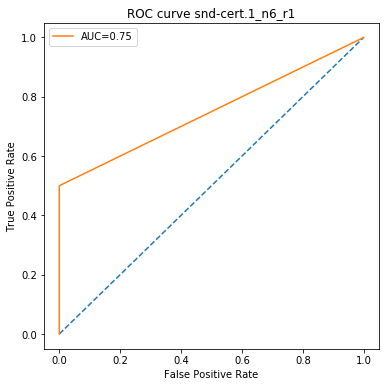

Execute command: !java -jar negative-selection/negsel2.jar -alphabet file://negative-selection/syscalls/snd-cert/snd-cert.alpha -self syscalls-classification/snd-cert/snd-cert.6.train -n 6 -r 1 -c -l < syscalls-classification/snd-cert/snd-cert.6.2.test
AUC: 0.75764


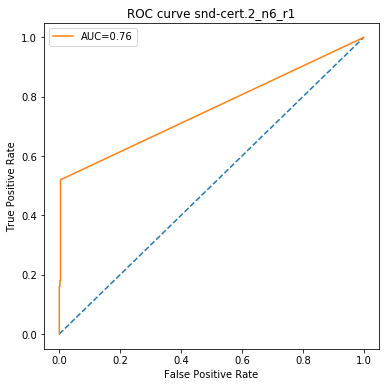

Execute command: !java -jar negative-selection/negsel2.jar -alphabet file://negative-selection/syscalls/snd-cert/snd-cert.alpha -self syscalls-classification/snd-cert/snd-cert.6.train -n 6 -r 1 -c -l < syscalls-classification/snd-cert/snd-cert.6.3.test
AUC: 0.7476499999999999


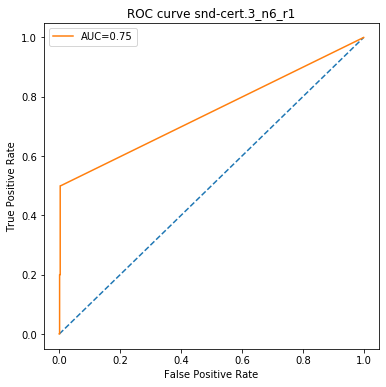

Execute command: !java -jar negative-selection/negsel2.jar -alphabet file://negative-selection/syscalls/snd-cert/snd-cert.alpha -self syscalls-classification/snd-cert/snd-cert.6.train -n 6 -r 2 -c -l < syscalls-classification/snd-cert/snd-cert.6.1.test
AUC: 0.97


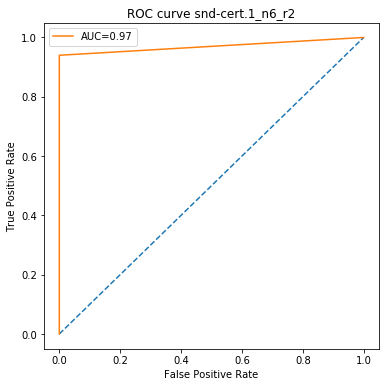

Execute command: !java -jar negative-selection/negsel2.jar -alphabet file://negative-selection/syscalls/snd-cert/snd-cert.alpha -self syscalls-classification/snd-cert/snd-cert.6.train -n 6 -r 2 -c -l < syscalls-classification/snd-cert/snd-cert.6.2.test
AUC: 0.96348


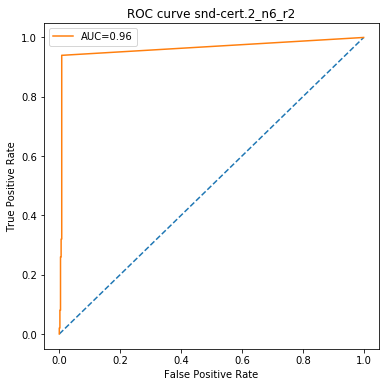

Execute command: !java -jar negative-selection/negsel2.jar -alphabet file://negative-selection/syscalls/snd-cert/snd-cert.alpha -self syscalls-classification/snd-cert/snd-cert.6.train -n 6 -r 2 -c -l < syscalls-classification/snd-cert/snd-cert.6.3.test
AUC: 0.97388


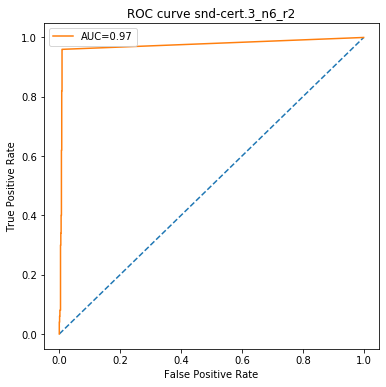

Execute command: !java -jar negative-selection/negsel2.jar -alphabet file://negative-selection/syscalls/snd-cert/snd-cert.alpha -self syscalls-classification/snd-cert/snd-cert.6.train -n 6 -r 3 -c -l < syscalls-classification/snd-cert/snd-cert.6.1.test
AUC: 0.9674


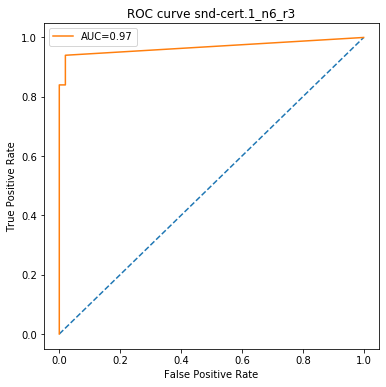

Execute command: !java -jar negative-selection/negsel2.jar -alphabet file://negative-selection/syscalls/snd-cert/snd-cert.alpha -self syscalls-classification/snd-cert/snd-cert.6.train -n 6 -r 3 -c -l < syscalls-classification/snd-cert/snd-cert.6.2.test
AUC: 0.96316


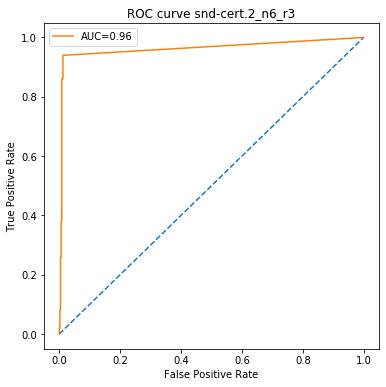

Execute command: !java -jar negative-selection/negsel2.jar -alphabet file://negative-selection/syscalls/snd-cert/snd-cert.alpha -self syscalls-classification/snd-cert/snd-cert.6.train -n 6 -r 3 -c -l < syscalls-classification/snd-cert/snd-cert.6.3.test
AUC: 0.9735199999999999


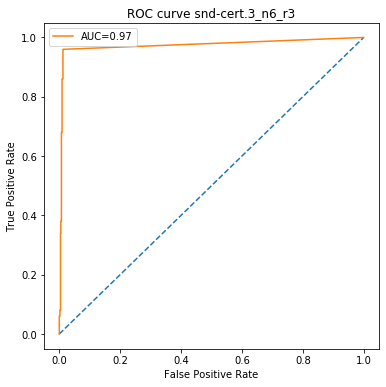

Execute command: !java -jar negative-selection/negsel2.jar -alphabet file://negative-selection/syscalls/snd-cert/snd-cert.alpha -self syscalls-classification/snd-cert/snd-cert.6.train -n 6 -r 4 -c -l < syscalls-classification/snd-cert/snd-cert.6.1.test
AUC: 0.9772


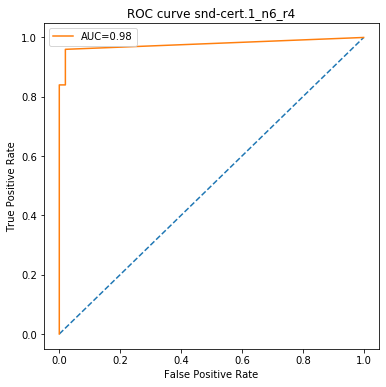

Execute command: !java -jar negative-selection/negsel2.jar -alphabet file://negative-selection/syscalls/snd-cert/snd-cert.alpha -self syscalls-classification/snd-cert/snd-cert.6.train -n 6 -r 4 -c -l < syscalls-classification/snd-cert/snd-cert.6.2.test
AUC: 0.96336


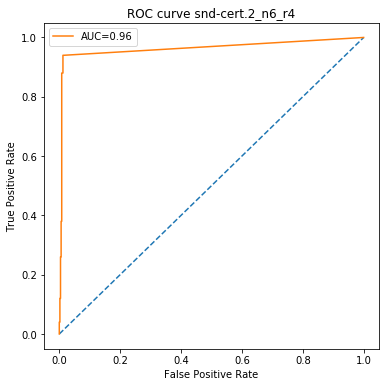

Execute command: !java -jar negative-selection/negsel2.jar -alphabet file://negative-selection/syscalls/snd-cert/snd-cert.alpha -self syscalls-classification/snd-cert/snd-cert.6.train -n 6 -r 4 -c -l < syscalls-classification/snd-cert/snd-cert.6.3.test
AUC: 0.9738199999999999


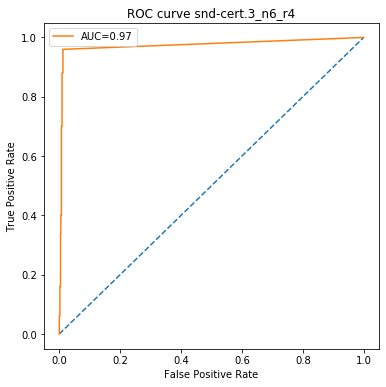

Execute command: !java -jar negative-selection/negsel2.jar -alphabet file://negative-selection/syscalls/snd-cert/snd-cert.alpha -self syscalls-classification/snd-cert/snd-cert.6.train -n 6 -r 5 -c -l < syscalls-classification/snd-cert/snd-cert.6.1.test
AUC: 0.9772


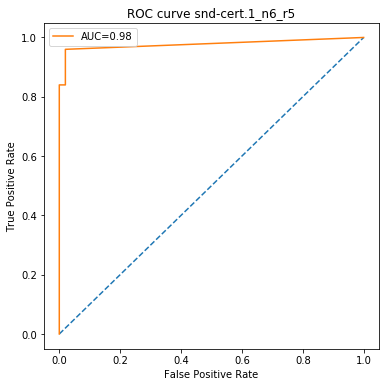

Execute command: !java -jar negative-selection/negsel2.jar -alphabet file://negative-selection/syscalls/snd-cert/snd-cert.alpha -self syscalls-classification/snd-cert/snd-cert.6.train -n 6 -r 5 -c -l < syscalls-classification/snd-cert/snd-cert.6.2.test
AUC: 0.9628999999999999


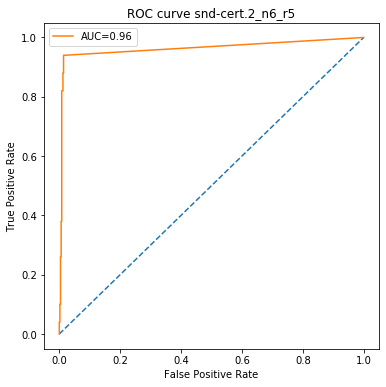

Execute command: !java -jar negative-selection/negsel2.jar -alphabet file://negative-selection/syscalls/snd-cert/snd-cert.alpha -self syscalls-classification/snd-cert/snd-cert.6.train -n 6 -r 5 -c -l < syscalls-classification/snd-cert/snd-cert.6.3.test
AUC: 0.9734799999999999


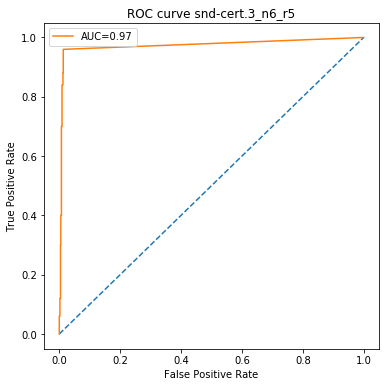

Execute command: !java -jar negative-selection/negsel2.jar -alphabet file://negative-selection/syscalls/snd-cert/snd-cert.alpha -self syscalls-classification/snd-cert/snd-cert.6.train -n 6 -r 6 -c -l < syscalls-classification/snd-cert/snd-cert.6.1.test
AUC: 0.9772


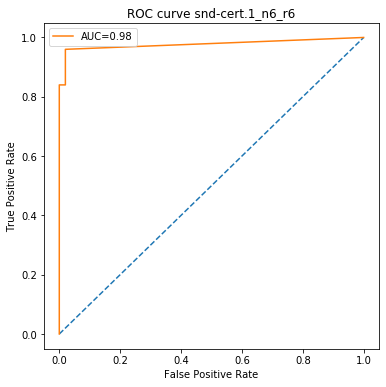

Execute command: !java -jar negative-selection/negsel2.jar -alphabet file://negative-selection/syscalls/snd-cert/snd-cert.alpha -self syscalls-classification/snd-cert/snd-cert.6.train -n 6 -r 6 -c -l < syscalls-classification/snd-cert/snd-cert.6.2.test
AUC: 0.96322


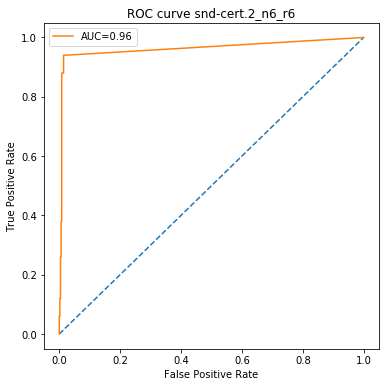

Execute command: !java -jar negative-selection/negsel2.jar -alphabet file://negative-selection/syscalls/snd-cert/snd-cert.alpha -self syscalls-classification/snd-cert/snd-cert.6.train -n 6 -r 6 -c -l < syscalls-classification/snd-cert/snd-cert.6.3.test
AUC: 0.9737799999999999


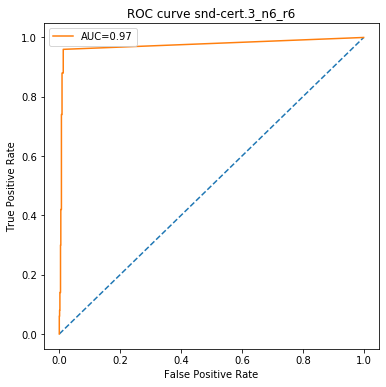

Execute command: !java -jar negative-selection/negsel2.jar -alphabet file://negative-selection/syscalls/snd-cert/snd-cert.alpha -self syscalls-classification/snd-cert/snd-cert.7.train -n 7 -r 1 -c -l < syscalls-classification/snd-cert/snd-cert.7.1.test
AUC: 0.8200000000000001


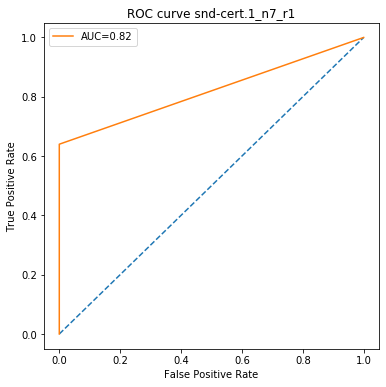

Execute command: !java -jar negative-selection/negsel2.jar -alphabet file://negative-selection/syscalls/snd-cert/snd-cert.alpha -self syscalls-classification/snd-cert/snd-cert.7.train -n 7 -r 1 -c -l < syscalls-classification/snd-cert/snd-cert.7.2.test
AUC: 0.80416


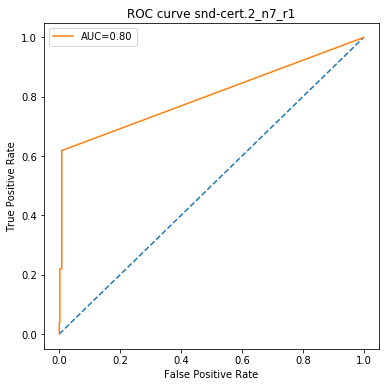

Execute command: !java -jar negative-selection/negsel2.jar -alphabet file://negative-selection/syscalls/snd-cert/snd-cert.alpha -self syscalls-classification/snd-cert/snd-cert.7.train -n 7 -r 1 -c -l < syscalls-classification/snd-cert/snd-cert.7.3.test
AUC: 0.80572


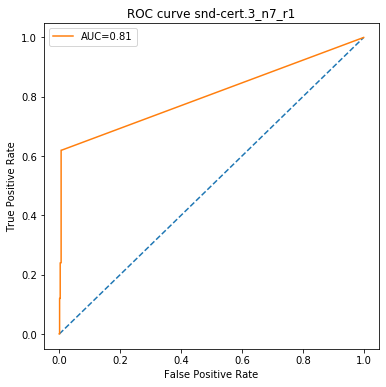

Execute command: !java -jar negative-selection/negsel2.jar -alphabet file://negative-selection/syscalls/snd-cert/snd-cert.alpha -self syscalls-classification/snd-cert/snd-cert.7.train -n 7 -r 2 -c -l < syscalls-classification/snd-cert/snd-cert.7.1.test
AUC: 0.9795999999999999


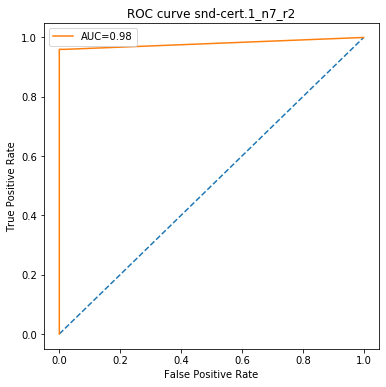

Execute command: !java -jar negative-selection/negsel2.jar -alphabet file://negative-selection/syscalls/snd-cert/snd-cert.alpha -self syscalls-classification/snd-cert/snd-cert.7.train -n 7 -r 2 -c -l < syscalls-classification/snd-cert/snd-cert.7.2.test
AUC: 0.9636


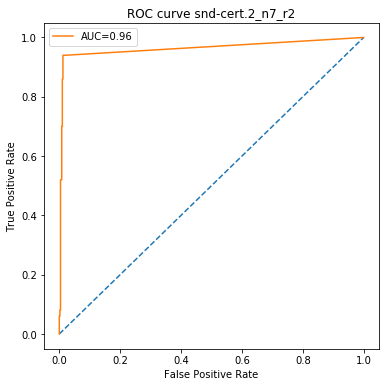

Execute command: !java -jar negative-selection/negsel2.jar -alphabet file://negative-selection/syscalls/snd-cert/snd-cert.alpha -self syscalls-classification/snd-cert/snd-cert.7.train -n 7 -r 2 -c -l < syscalls-classification/snd-cert/snd-cert.7.3.test
AUC: 0.9751199999999999


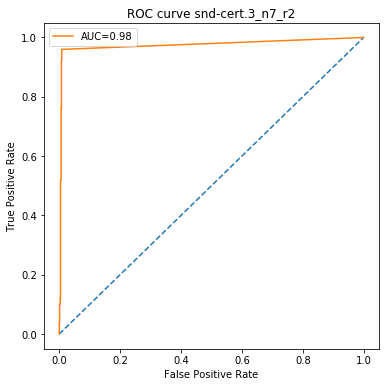

Execute command: !java -jar negative-selection/negsel2.jar -alphabet file://negative-selection/syscalls/snd-cert/snd-cert.alpha -self syscalls-classification/snd-cert/snd-cert.7.train -n 7 -r 3 -c -l < syscalls-classification/snd-cert/snd-cert.7.1.test
AUC: 0.9787999999999999


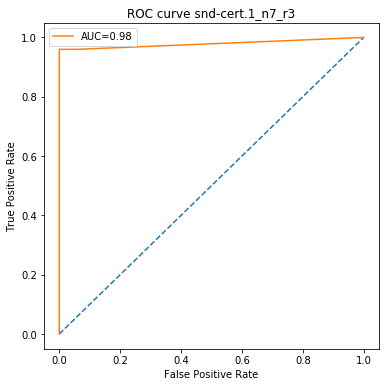

Execute command: !java -jar negative-selection/negsel2.jar -alphabet file://negative-selection/syscalls/snd-cert/snd-cert.alpha -self syscalls-classification/snd-cert/snd-cert.7.train -n 7 -r 3 -c -l < syscalls-classification/snd-cert/snd-cert.7.2.test
AUC: 0.98474


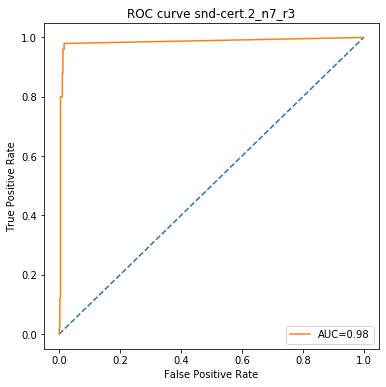

Execute command: !java -jar negative-selection/negsel2.jar -alphabet file://negative-selection/syscalls/snd-cert/snd-cert.alpha -self syscalls-classification/snd-cert/snd-cert.7.train -n 7 -r 3 -c -l < syscalls-classification/snd-cert/snd-cert.7.3.test
AUC: 0.9756


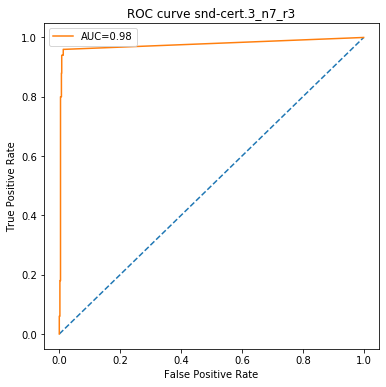

Execute command: !java -jar negative-selection/negsel2.jar -alphabet file://negative-selection/syscalls/snd-cert/snd-cert.alpha -self syscalls-classification/snd-cert/snd-cert.7.train -n 7 -r 4 -c -l < syscalls-classification/snd-cert/snd-cert.7.1.test
AUC: 0.9787999999999999


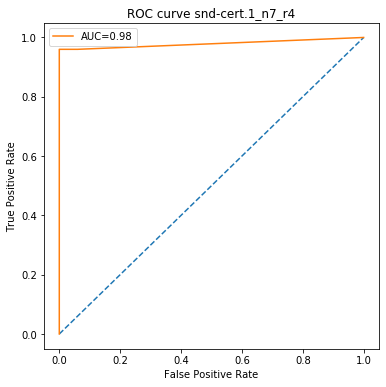

Execute command: !java -jar negative-selection/negsel2.jar -alphabet file://negative-selection/syscalls/snd-cert/snd-cert.alpha -self syscalls-classification/snd-cert/snd-cert.7.train -n 7 -r 4 -c -l < syscalls-classification/snd-cert/snd-cert.7.2.test
AUC: 0.98502


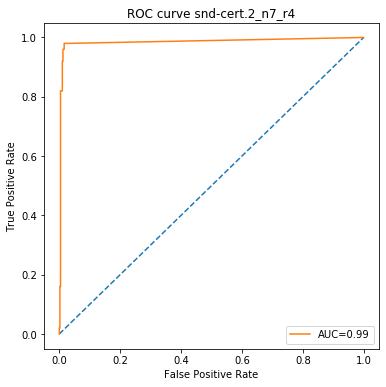

Execute command: !java -jar negative-selection/negsel2.jar -alphabet file://negative-selection/syscalls/snd-cert/snd-cert.alpha -self syscalls-classification/snd-cert/snd-cert.7.train -n 7 -r 4 -c -l < syscalls-classification/snd-cert/snd-cert.7.3.test
AUC: 0.97568


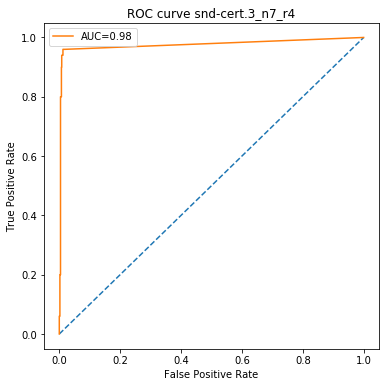

Execute command: !java -jar negative-selection/negsel2.jar -alphabet file://negative-selection/syscalls/snd-cert/snd-cert.alpha -self syscalls-classification/snd-cert/snd-cert.7.train -n 7 -r 5 -c -l < syscalls-classification/snd-cert/snd-cert.7.1.test
AUC: 0.9787999999999999


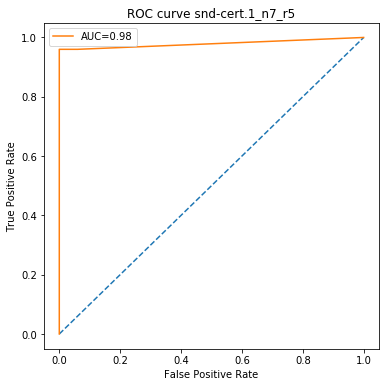

Execute command: !java -jar negative-selection/negsel2.jar -alphabet file://negative-selection/syscalls/snd-cert/snd-cert.alpha -self syscalls-classification/snd-cert/snd-cert.7.train -n 7 -r 5 -c -l < syscalls-classification/snd-cert/snd-cert.7.2.test
AUC: 0.985


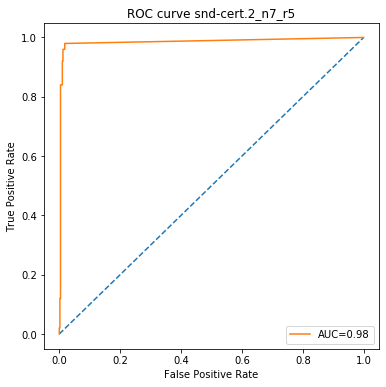

Execute command: !java -jar negative-selection/negsel2.jar -alphabet file://negative-selection/syscalls/snd-cert/snd-cert.alpha -self syscalls-classification/snd-cert/snd-cert.7.train -n 7 -r 5 -c -l < syscalls-classification/snd-cert/snd-cert.7.3.test
AUC: 0.9756199999999999


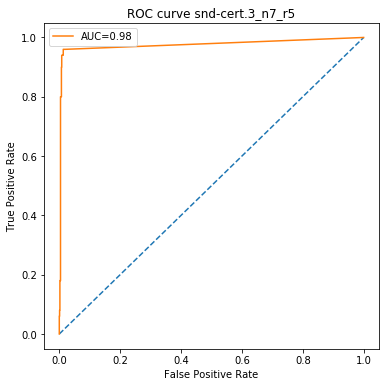

Execute command: !java -jar negative-selection/negsel2.jar -alphabet file://negative-selection/syscalls/snd-cert/snd-cert.alpha -self syscalls-classification/snd-cert/snd-cert.7.train -n 7 -r 6 -c -l < syscalls-classification/snd-cert/snd-cert.7.1.test
AUC: 0.9787999999999999


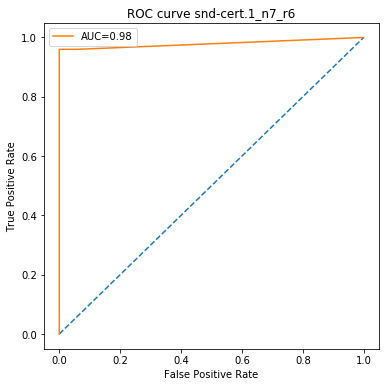

Execute command: !java -jar negative-selection/negsel2.jar -alphabet file://negative-selection/syscalls/snd-cert/snd-cert.alpha -self syscalls-classification/snd-cert/snd-cert.7.train -n 7 -r 6 -c -l < syscalls-classification/snd-cert/snd-cert.7.2.test
AUC: 0.9848399999999999


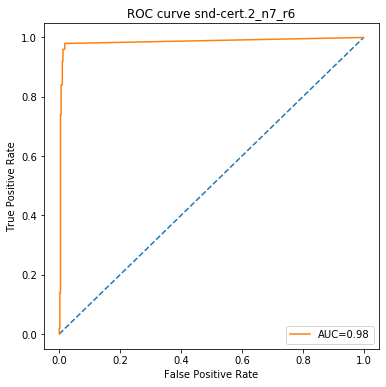

Execute command: !java -jar negative-selection/negsel2.jar -alphabet file://negative-selection/syscalls/snd-cert/snd-cert.alpha -self syscalls-classification/snd-cert/snd-cert.7.train -n 7 -r 6 -c -l < syscalls-classification/snd-cert/snd-cert.7.3.test
AUC: 0.9757199999999999


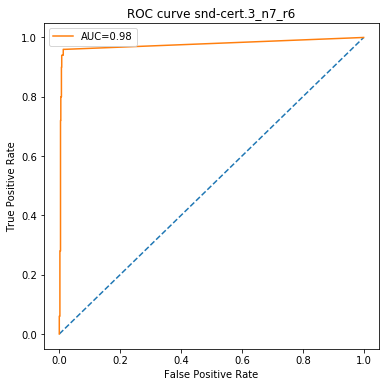

Execute command: !java -jar negative-selection/negsel2.jar -alphabet file://negative-selection/syscalls/snd-cert/snd-cert.alpha -self syscalls-classification/snd-cert/snd-cert.7.train -n 7 -r 7 -c -l < syscalls-classification/snd-cert/snd-cert.7.1.test
AUC: 0.9787999999999999


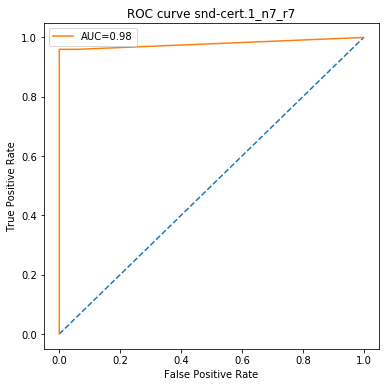

Execute command: !java -jar negative-selection/negsel2.jar -alphabet file://negative-selection/syscalls/snd-cert/snd-cert.alpha -self syscalls-classification/snd-cert/snd-cert.7.train -n 7 -r 7 -c -l < syscalls-classification/snd-cert/snd-cert.7.2.test
AUC: 0.9847799999999999


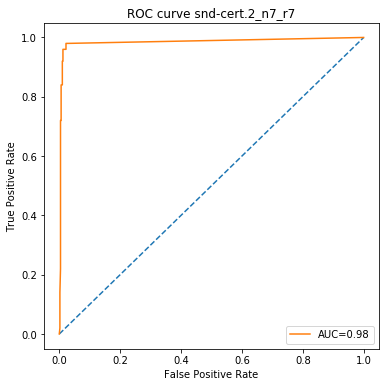

Execute command: !java -jar negative-selection/negsel2.jar -alphabet file://negative-selection/syscalls/snd-cert/snd-cert.alpha -self syscalls-classification/snd-cert/snd-cert.7.train -n 7 -r 7 -c -l < syscalls-classification/snd-cert/snd-cert.7.3.test
AUC: 0.97571


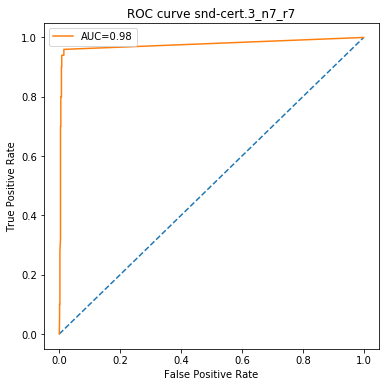

In [12]:
for n, r in chunk_r_tuples:
    self = f"-self {cert_data_path}snd-cert.{n}.train"
    params = f"-n {n} -r {r} -c -l"
    for i in range(1, TEST_N + 1):
        test = f"{cert_data_path}snd-cert.{n}.{i}.test"
        # run negative selection algorithm
        print(f"Execute command: !java {jar} {alpha} {self} {params} < {test}")
        output = !java {jar} {alpha} {self} {params} < {test}
        # convert to floa and numpy array
        counts = np.array([float(count) for count in output])
        # read idx and convert to numpy array
        idx = read_data(cert_data_path + "snd-cert.{}.{}.txt".format(n, i))
        idx = np.array(idx).astype(float)
        # read labels and convert to float
        labels = read_data(cert_data_path + "snd-cert.{}.{}.labels".format(n, i))
        labels = np.array([float(label) for label in labels])
        # compute composite counts and labels
        comp_counts = [np.average(counts[np.where(idx==k)]) for k in range(int(idx[-1]+1))]
        comp_labels = [labels[np.where(idx==k)[0][0]] for k in range(int(idx[-1]+1))]
        # perform AUC analysis - compute AUC and plot ROC
        fpr, tpr, thresholds = metrics.roc_curve(comp_labels, comp_counts, pos_label=1)
        auc = get_AUC(comp_labels, comp_counts)
        print("AUC:", auc)
        plot_ROC(fpr, tpr, "snd-cert.{}_n{}_r{}".format(i, n, r),
                 "ex2_snd-cert.comp.{}_n{}_r{}".format(i, n, r))
        # store AUC in a dictionary
        auc_dict["snd-cert.{}_n{}_r{}".format(i, n, r)] = auc
    print("=================")

In [13]:
# save auc_dict
with open('auc_dict_cert_comp.pkl', 'wb') as output:
    pickle.dump(auc_dict, output, pickle.HIGHEST_PROTOCOL)

### Step 3: AUC Analysis Task

In [14]:
# load auc_dict
with open('auc_dict_cert_comp.pkl', 'rb') as output:
    auc_dict = pickle.load(output)

In [15]:
avg_auc_dict = dict()
for n,r in chunk_r_tuples:
    auc_vals = [v for k,v in auc_dict.items() if 'n{}_r{}'.format(n,r) in k]
    avg_auc_dict[(n,r)] = np.average(auc_vals)

In [16]:
def plot_auc_over_r(n, auc, filename=None):
    
    plt.figure(figsize=(8, 6))
    for i in range(len(n)):
        r_range = range(1, n[i]+1)
        plt.plot(r_range, auc[i], label="n = {}".format(n[i]))
    plt.xlabel("$r$")
    plt.ylabel("AUC")
    plt.title("AUC for different values of $r$", size=14)
    plt.xticks(r_range)
    plt.ylim(top=1)
    plt.legend()
    plt.grid()
    if filename:
        plt.savefig(f'figures/{filename}.png')
    plt.show()

In [17]:
auc = [[v for k,v in avg_auc_dict.items() if k[0]==i] for i in range(6, CHUNK_LENGTH+1)]
n = [i for i in range(6, CHUNK_LENGTH+1)]

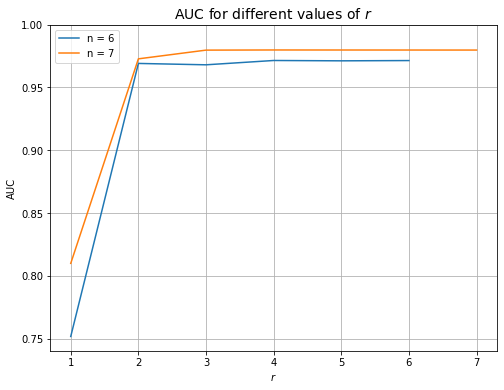

In [18]:
plot_auc_over_r(n, auc, 'ex2_snd-cert_comp.auc')